In [1]:
import numpy as np
from nozzle import Spectral, Params, Nozzle
import matplotlib.pyplot as plt

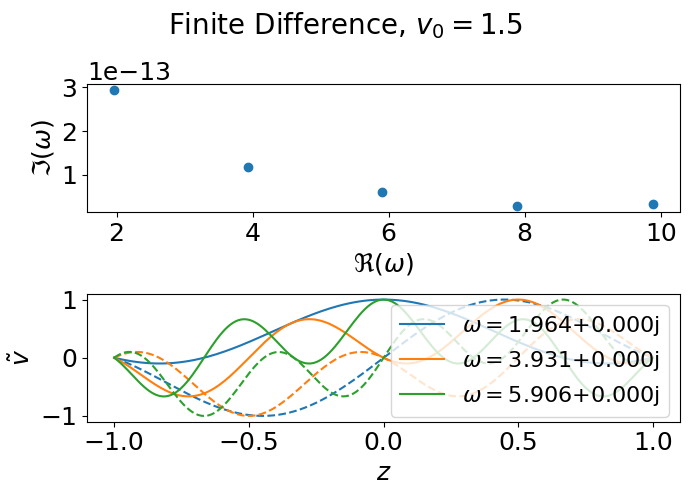

In [4]:
N = 201
Mm = 1.5
constant_v = True
accelerating = False
eta = 0 # diffusion

params = Params(Mm, constant_v=constant_v)
spectral = Spectral(N, "symmetric", "FD")
nozzle = Nozzle(params, spectral.x)
v0 = nozzle.v0
x = spectral.x
D1 = spectral.D1
D2 = spectral.D2

A11 = np.zeros_like(D1)
A12 = np.eye(*D1.shape)
A21 = -np.diag(1-v0**2)@D2 \
        + np.diag((3*v0 + 1/v0)*(D1@v0))@D1 \
        + np.diag((1-1/v0**2)*(D1@v0)**2) \
        + np.diag((v0+1/v0)*(D2@v0))
A22 = -2j*(np.diag(v0)@D1 + np.diag(D1@v0)) - eta*np.diag(v0)@D2

A = np.block([[A11[1:-1,1:-1], A12[1:-1,1:-1]],[A21[1:-1,1:-1], A22[1:-1,1:-1]]])
nozzle.solve(A)
nozzle.sort_solutions(real_range=[0,10], imag_range=[-1,1])

fig, ax = plt.subplots(2,1, figsize=(7,5))
nozzle.plot_eigenvalues(ax=ax[0])
nozzle.plot_eigenfunctions(ax=ax[1])
fig.suptitle(f"Finite Difference, $v_0={Mm}$")
plt.tight_layout()

nozzle.save_data("FD")